In [14]:
import numpy as np
import pandas as pd

In [15]:
df = pd.read_parquet("/Users/riyaazkhan/Documents/Imperial_Maths/Algorithmic_Trading_Club/Projects/Horse-Racing-Project/Data/Processed/XGBoost_Dataset.v2_trimmed.parquet")

In [11]:
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
from pathlib import Path

def csv_to_parquet_chunked_drop_col10(
    csv_path,
    out_path=None,
    *,
    chunksize=1_000_000,
    dayfirst=True,           # used in explicit to_datetime below
    force_date_as="datetime",# "datetime" or "string"
    compression="snappy"
):
    """
    Convert CSV -> Parquet in chunks, dropping column at positional index 10 (0-based),
    and forcing a consistent dtype for 'date' across all chunks.
    """
    csv_path = Path(csv_path)
    out_path = Path(out_path) if out_path else csv_path.with_suffix(".parquet")
    if out_path.suffix.lower() != ".parquet":
        out_path = out_path.with_suffix(".parquet")

    # Read header to build usecols excluding index 10
    header_cols = pd.read_csv(csv_path, nrows=0).columns.tolist()
    # keep all except the 11th column
    if len(header_cols) > 10:
        usecols = [c for i, c in enumerate(header_cols) if i != 10]
        dropped = header_cols[10]
    else:
        usecols = header_cols
        dropped = None

    writer = None
    for chunk in pd.read_csv(
        csv_path,
        chunksize=chunksize,
        usecols=usecols,     # <-- exclude problematic column at read time
        low_memory=False     # consistent dtype inference within a chunk
        # no parse_dates here; we convert explicitly below
    ):
        # Force consistent 'date' dtype every chunk
        if "date" in chunk.columns:
            if force_date_as == "datetime":
                # convert in-place; invalid parses -> NaT
                chunk["date"] = pd.to_datetime(chunk["date"], errors="coerce", dayfirst=dayfirst)
            elif force_date_as == "string":
                chunk["date"] = chunk["date"].astype("string")
            else:
                raise ValueError("force_date_as must be 'datetime' or 'string'")

        # (Optional) ensure identical column order each chunk
        chunk = chunk[usecols]

        table = pa.Table.from_pandas(chunk, preserve_index=False)
        if writer is None:
            writer = pq.ParquetWriter(out_path, table.schema, compression=compression)
        writer.write_table(table)

    if writer is not None:
        writer.close()

    msg = f"Wrote: {out_path}"
    if dropped:
        msg += f" (dropped column: {dropped})"
    return msg

# Example usage
print(csv_to_parquet_chunked_drop_col10(
    csv_path="/Users/riyaazkhan/Documents/Imperial_Maths/Algorithmic_Trading_Club/Projects/Horse-Racing-Project/Data/Processed/XGBoost_Dataset.v2_trimmed.csv",
    out_path="/Users/riyaazkhan/Documents/Imperial_Maths/Algorithmic_Trading_Club/Projects/Horse-Racing-Project/Data/Processed/XGBoost_Dataset.v2_trimmed.parquet",
    dayfirst=True,
    force_date_as="datetime"   # or "string" if you prefer keeping it textual
))


/var/folders/zh/vm69w9xx2dz7lj6rxj4mc08r0000gn/T/ipykernel_64042/3069182216.py:46: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  chunk["date"] = pd.to_datetime(chunk["date"], errors="coerce", dayfirst=dayfirst)
/var/folders/zh/vm69w9xx2dz7lj6rxj4mc08r0000gn/T/ipykernel_64042/3069182216.py:46: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  chunk["date"] = pd.to_datetime(chunk["date"], errors="coerce", dayfirst=dayfirst)


Wrote: /Users/riyaazkhan/Documents/Imperial_Maths/Algorithmic_Trading_Club/Projects/Horse-Racing-Project/Data/Processed/XGBoost_Dataset.v2_trimmed.parquet (dropped column: dist)


In [ ]:
#Maybe include margin, and res_place in the racers as a feature

In [16]:
from sklearn.preprocessing import LabelEncoder

# Example: your dataframe has a column 'country_code'
df['countryCode'] = df['countryCode'].astype('category')
df['headGear'] = df['headGear'].astype('category')
df['prev_headgear'] = df['prev_headgear'].astype('category')
df['course_clean'] = df['course_clean'].astype('category')
df['course_surface'] = df['course_surface'].astype('category')
df['track_layout'] = df['track_layout'].astype('category')
df['race_jump_type'] = df['race_jump_type'].astype('category')
df['best_dist_band_hist'] = df['best_dist_band_hist'].astype('category')

In [17]:
unnecessarycolumns = ['rid',
    'horseName','age','saddle','isFav','trainerName',
    'jockeyName','position','positionL',
    'weightSt','weightLb','RPR','TR','OR',
    'father','mother','gfather','runners',
    'margin','res_place','time','band_bins',
    'condition','hurdles','rclass','course',
    'prizes','winningTime','metric','source_year',
    'prev_raceId','close_finish','date2','title','saddle_rank_bin',
    'band_clean','band','ages','days_since_last_race_binned',
    'distance_banding','decimalPrice','race_age_band',
    'previous_trainer','previous_jockey']

df = df.drop(columns=unnecessarycolumns)

In [36]:
df['year'].unique()

array([1997, 2000, 2001, 2013, 2011, 2012, 2002, 2010, 2016, 2017, 2018,
       2005, 2003, 2004, 2014, 1998, 2009, 2006, 2007, 2008, 2019, 2015,
       1999])

In [18]:
tr_data = df[df['year'] <= 2014]
val_data = df[(df['year'] < 2018) & (df['year'] > 2014)]
cal_data = df[df['year'] == 2018]
bkt_data = df[df['year'] == 2019]


In [19]:
tr_data = tr_data.copy().sort_values('date')
val_data = val_data.copy().sort_values('date')
cal_date = cal_data.copy().sort_values('date')
bkt_data = bkt_data.copy().sort_values('date')

tr_data = tr_data.drop(columns='date')
val_data = val_data.drop(columns='date')
cal_data = cal_data.drop(columns='date')
bkt_data = bkt_data.drop(columns='date')

In [20]:
tr_data_y = tr_data['res_win']
tr_data_p = tr_data['betting_prob_win']
tr_data_x = tr_data.drop(columns=['res_win','betting_prob_win'])

val_data_y = val_data['res_win']
val_data_p = val_data['betting_prob_win']
val_data_x = val_data.drop(columns=['res_win','betting_prob_win'])

cal_data_y = cal_data['res_win']
cal_data_p = cal_data['betting_prob_win']
cal_data_x = cal_data.drop(columns=['res_win','betting_prob_win'])

bkt_data_y = bkt_data['res_win']
bkt_data_p = bkt_data['betting_prob_win']
bkt_data_x = bkt_data.drop(columns=['res_win','betting_prob_win'])

In [ ]:
import numpy as np
import pandas as pd
import time
import lightgbm as lgb

# ========= 1) SMALL, STRATIFIED SAMPLES (speed!) =========
def stratified_sample(X, y, frac=0.10, seed=42):
    """Return a stratified subset of rows (~frac of each class)."""
    rng = np.random.default_rng(seed)
    pos_idx = y[y == 1].index
    neg_idx = y[y == 0].index
    n_pos = max(1, int(len(pos_idx) * frac))
    n_neg = max(1, int(len(neg_idx) * frac))
    pick_pos = rng.choice(pos_idx, n_pos, replace=False)
    pick_neg = rng.choice(neg_idx, n_neg, replace=False)
    idx = np.concatenate([pick_pos, pick_neg])
    return X.loc[idx], y.loc[idx]

# tune on 5–10% for speed; also shrink validation during tuning
X_tune, y_tune = stratified_sample(tr_data_x, tr_data_y, frac=0.10, seed=42)
X_val_tune, y_val_tune = stratified_sample(val_data_x, val_data_y, frac=0.10, seed=123)

# keep categorical col list consistent
cat_cols = [c for c in X_tune.columns if str(X_tune[c].dtype) == 'category']

# ========= 2) BASE PARAMS (fast) + SMALL SEARCH SPACE =========
base = dict(
    objective='binary',
    n_estimators=1000,                # small cap; early stopping will halt earlier
    learning_rate=0.07,               # faster per-tree progress for tuning
    max_bin=127,                      # cheaper histograms
    bin_construct_sample_cnt=200_000, # speed up binning
    force_col_wise=True,              # faster for many features
    first_metric_only=True,           # early stopping focuses on first metric
    boosting_type='gbdt',             # (fast) Gradient-based One-Side Sampling
    top_rate=0.2, other_rate=0.1,     # GOSS params
    n_jobs=-1,
    #max_cat_to_onehot=0               # use partition-bas
    ed categorical handling
)

space = {
    "num_leaves":              [31, 63, 127],
    "min_data_in_leaf":        [150, 300, 500],
    "min_sum_hessian_in_leaf": [1.0, 5.0, 10.0],
    "feature_fraction":        [0.6, 0.75, 0.9],
    "feature_fraction_bynode": [0.6, 0.8, 0.9],
    "bagging_fraction":        [0.8, 0.9],    # ignored by GOSS (harmless to keep)
    "bagging_freq":            [1],
    "lambda_l1":               [0.0, 1.0, 3.0],
    "lambda_l2":               [0.0, 3.0, 8.0],
    "min_gain_to_split":       [0.0, 0.05]
}

def pick(rng, d):  # random sampler for the small search space
    return {k: rng.choice(v) for k, v in d.items()}

# ========= 3) QUICK RANDOM SEARCH (6–10 trials) =========
rng = np.random.default_rng(777)
best = {"logloss": 1e9, "auc": None, "params": None, "iters": None, "secs": None}

for i in range(8):  # try 6–10 quick configs
    params = {**base, **pick(rng, space)}
    model = lgb.LGBMClassifier(**params)

    t0 = time.time()
    model.fit(
        X_tune, y_tune,
        eval_set=[(X_val_tune, y_val_tune)],
        eval_metric=['binary_logloss', 'auc'],  # first one used for early stopping
        categorical_feature=cat_cols,
        callbacks=[lgb.early_stopping(80), lgb.log_evaluation(200)]
    )
    secs = time.time() - t0

    ll  = model.best_score_['valid_0']['binary_logloss']
    auc = model.best_score_['valid_0']['auc']
    it  = model.best_iteration_

    print(f"[Trial {i+1:02d}] ll={ll:.6f} auc={auc:.6f} iters={it} time={secs:.1f}s params={params}")

    if ll < best["logloss"]:
        best.update({"logloss": ll, "auc": auc, "params": params, "iters": it, "secs": secs})

print("\n=== BEST ON TUNE SUBSET ===")
print(f"LogLoss={best['logloss']:.6f} | AUC={best['auc']:.6f} | iters={best['iters']} | time={best['secs']:.1f}s")
print("Params:", best["params"])

# ========= 4) REFIT BEST ON FULL TRAIN (proper settings) =========
# Switch back to standard GBDT, lower LR, larger n_estimators; keep structure regs from best
final_params = {**best["params"]}
final_params.update(dict(
    boosting_type='gbdt',   # standard boosting for best accuracy
    learning_rate=0.02,     # safer LR
    n_estimators=5000,      # rely on early stopping
    first_metric_only=False # log both metrics nicely
))

final = lgb.LGBMClassifier(**final_params)
final.fit(
    tr_data_x, tr_data_y,
    eval_set=[(val_data_x, val_data_y)],
    eval_metric=['binary_logloss', 'auc'],
    categorical_feature=cat_cols,
    callbacks=[lgb.early_stopping(200), lgb.log_evaluation(200)]
)

print("\n=== REFIT ON FULL TRAIN ===")
print("Val logloss:", final.best_score_['valid_0']['binary_logloss'])
print("Val AUC:",     final.best_score_['valid_0']['auc'])
print("Best iteration:", final.best_iteration_)


In [13]:
import lightgbm as lgb
best_params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'first_metric_only': True,     # make sure 'binary_logloss' is first in eval_metric
    'learning_rate': 0.07,         # from your best-on-subset
    'n_estimators': 5000,          # ceiling; rely on early stopping(200)
    'num_leaves': 31,
    'max_bin': 127,
    'bin_construct_sample_cnt': 200000,  # alias of subsample_for_bin
    'min_data_in_leaf': 300,
    'min_sum_hessian_in_leaf': 10.0,
    'feature_fraction': 0.6,       # alias of colsample_bytree
    'feature_fraction_bynode': 0.8,
    'bagging_fraction': 0.8,       # alias of subsample
    'bagging_freq': 1,
    'lambda_l1': 1.0,
    'lambda_l2': 8.0,
    'min_gain_to_split': 0.05,
    'force_col_wise': True,
    'n_jobs': -1
}

modelv1 = lgb.LGBMClassifier(**best_params)


In [14]:
df = df.sort_values('date')

In [15]:
modelv1.fit(
    tr_data_x, tr_data_y,
    eval_set=[(val_data_x, val_data_y)],
    eval_metric='logloss',                    # or 'auc'
    categorical_feature=[c for c in tr_data_x.columns if str(tr_data_x[c].dtype)=='category'],
    callbacks=[lgb.early_stopping(stopping_rounds=200), lgb.log_evaluation(100)]
)

[LightGBM] [Warning] bin_construct_sample_cnt is set=200000, subsample_for_bin=200000 will be ignored. Current value: bin_construct_sample_cnt=200000
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] lambda_l1 is set=1.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.0
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=0.05, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.05
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=10.0, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=10.0
[LightGBM]

LGBMClassifier(bagging_fraction=0.8, bagging_freq=1,
               bin_construct_sample_cnt=200000, feature_fraction=0.6,
               feature_fraction_bynode=0.8, first_metric_only=True,
               force_col_wise=True, lambda_l1=1.0, lambda_l2=8.0,
               learning_rate=0.07, max_bin=127, min_data_in_leaf=300,
               min_gain_to_split=0.05, min_sum_hessian_in_leaf=10.0,
               n_estimators=5000, n_jobs=-1, objective='binary')

In [16]:
val_preds = modelv1.predict_proba(val_data_x, num_iteration=modelv1.best_iteration_)[:, 1]

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bin_construct_sample_cnt is set=200000, subsample_for_bin=200000 will be ignored. Current value: bin_construct_sample_cnt=200000
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.0
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=0.05, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.05
[LightGBM] [Warning] lambda_l1 is set=1.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0
[LightGBM] [Warning] min_sum_hessian_in_leaf

In [ ]:
#Best Score on full dataset
Logloss: 0.257044

AUC: 0.818583

Best iteration: 5000 trees


In [17]:
import pandas as pd
import numpy as np
from sklearn.metrics import log_loss

def blend_logloss_from_csv(model, X_valid, y_valid,
                           p_cat_csv_path="/content/p_cat_valid.csv",
                           id_col=None, x_id_col=None, p_cat_col="p_cat",
                           alpha=0.5, return_preds=False):
    """
    Blend CatBoost probs from CSV with LightGBM probs and compute log loss.

    Parameters
    ----------
    model : fitted LightGBM model (e.g., LGBMClassifier) with predict_proba
    X_valid : DataFrame or array of validation features
    y_valid : array-like of 0/1 labels for validation set
    p_cat_csv_path : path to CSV containing a column with p_cat probabilities
    id_col : optional column name in the CSV to align on (e.g., 'rid')
    x_id_col : optional column name in X_valid with the same IDs for alignment
    p_cat_col : name of the p_cat column in the CSV (default 'p_cat')
    alpha : weight for LightGBM in the blend; blend = alpha*LGBM + (1-alpha)*Cat
    return_preds : if True, also return a DataFrame of y, p_lgb, p_cat, p_blend

    Returns
    -------
    metrics : dict with logloss_lgbm, logloss_cat, logloss_blend, alpha
    (optionally) df_out : DataFrame of predictions if return_preds=True
    """
    df = pd.read_csv(p_cat_csv_path)

    # Align p_cat to X_valid
    if id_col is not None and x_id_col is not None:
        if hasattr(X_valid, "columns") and x_id_col in X_valid.columns and id_col in df.columns:
            key = pd.Series(X_valid[x_id_col]).astype(df[id_col].dtype)
            aligned = df.set_index(id_col).reindex(key.values)
            p_cat = aligned[p_cat_col].to_numpy()
        else:
            raise ValueError("ID alignment requested, but id_col/x_id_col not found in data.")
    else:
        if len(df) != len(X_valid):
            raise ValueError(f"Row mismatch: CSV has {len(df)}, X_valid has {len(X_valid)}."
                             " Provide id_col and x_id_col to align by ID.")
        p_cat = df[p_cat_col].to_numpy()

    # LightGBM probabilities (handle best_iteration if present)
    best_iter = getattr(model, "best_iteration_", None) or getattr(model, "best_iteration", None)
    try:
        p_lgb = model.predict_proba(X_valid, num_iteration=best_iter)[:, 1]
    except TypeError:
        p_lgb = model.predict_proba(X_valid)[:, 1]

    y = np.asarray(y_valid)
    p_blend = alpha * p_lgb + (1.0 - alpha) * p_cat

    metrics = {
        "logloss_lgbm": float(log_loss(y, p_lgb)),
        "logloss_cat": float(log_loss(y, p_cat)),
        "logloss_blend": float(log_loss(y, p_blend)),
        "alpha": float(alpha),
    }

    if return_preds:
        df_out = pd.DataFrame({
            "y_valid": y,
            "p_lgb": p_lgb,
            "p_cat": p_cat,
            "p_blend": p_blend
        })
        return metrics, df_out

    return metrics


In [18]:
# Equal-weight blend; CSV at /content/p_cat_valid.csv with column 'p_cat'
metrics, preds = blend_logloss_from_csv(
    model=modelv1,
    X_valid=val_data_x,
    y_valid=val_data_y,
    p_cat_csv_path="/Users/riyaazkhan/Documents/Imperial_Maths/Algorithmic_Trading_Club/Projects/Horse-Racing-Project/Models/p_cat_valid.csv",
    # If both the CSV and X have an ID column (e.g., 'rid'), uncomment these:
    # id_col="rid", x_id_col="rid",
    alpha=0.5,
    return_preds=True
)

print(metrics)          # shows logloss_lgbm, logloss_cat, logloss_blend
#preds.to_csv("/content/p_blend_valid.csv", index=False)  # optional: save blended preds


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bin_construct_sample_cnt is set=200000, subsample_for_bin=200000 will be ignored. Current value: bin_construct_sample_cnt=200000
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.0
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=0.05, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.05
[LightGBM] [Warning] lambda_l1 is set=1.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0
[LightGBM] [Warning] min_sum_hessian_in_leaf

In [21]:
#LightGBM is significantly better: Saving the model 
import joblib, json

# 1) Save the sklearn model
joblib.dump(modelv1, "lgbm_model.pkl")

# 2) Save useful metadata
best_iter = getattr(modelv1, "best_iteration_", None) or getattr(modelv1, "best_iteration", None)
feature_names = list(tr_data_x.columns)  # or val_data_x.columns if that’s your schema
json.dump(
    {"feature_names": feature_names, "best_iteration": best_iter},
    open("lgbm_meta.json","w")
)


In [22]:
#Loading the model
import joblib, json, pandas as pd

modelv1 = joblib.load("lgbm_model.pkl")
meta = json.load(open("lgbm_meta.json"))
feat = meta["feature_names"]; best_iter = meta["best_iteration"]

# enforce same columns/order at inference
def enforce_schema(df, cols):
    df2 = df.copy()
    for c in cols:
        if c not in df2:
            df2[c] = 0
    return df2[cols]

#X_new = enforce_schema(new_data[feat], feat)
#p = modelv1.predict_proba(X_new, num_iteration=best_iter)[:, 1]

In [23]:
val_preds = modelv1.predict_proba(val_data_x, num_iteration=modelv1.best_iteration_)[:, 1]

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bin_construct_sample_cnt is set=200000, subsample_for_bin=200000 will be ignored. Current value: bin_construct_sample_cnt=200000
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.0
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=0.05, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.05
[LightGBM] [Warning] lambda_l1 is set=1.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0
[LightGBM] [Warning] min_sum_hessian_in_leaf

In [24]:
from sklearn.metrics import log_loss
print("logloss_lgbm",  float(log_loss(val_data_y, val_preds)),

SyntaxError: unexpected EOF while parsing (2135759259.py, line 2)

In [25]:
#Now Calibrating either using Platt Scaling/Isotonic
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss, brier_score_loss, roc_auc_score


from sklearn.calibration import CalibratedClassifierCV
cal = CalibratedClassifierCV(modelv1, method="sigmoid", cv="prefit")  # or "sigmoid"
cal.fit(cal_data_x, cal_data_y)

# 3) evaluate/backtest on 2019
best_iter = getattr(modelv1, "best_iteration_", None) or getattr(modelv1, "best_iteration", None)
p_raw = modelv1.predict_proba(bkt_data_x, num_iteration=best_iter)[:, 1]
p_cal = cal.predict_proba(bkt_data_x)[:, 1]

print("LogLoss raw :", log_loss(bkt_data_y, p_raw))
print("LogLoss cal :", log_loss(bkt_data_y, p_cal))
print("Brier  raw  :", brier_score_loss(bkt_data_y, p_raw))
print("Brier  cal  :", brier_score_loss(bkt_data_y, p_cal))
print("AUC raw/cal :", roc_auc_score(bkt_data_y, p_raw), roc_auc_score(bkt_data_y, p_cal))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bin_construct_sample_cnt is set=200000, subsample_for_bin=200000 will be ignored. Current value: bin_construct_sample_cnt=200000
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.0
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=0.05, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.05
[LightGBM] [Warning] lambda_l1 is set=1.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0
[LightGBM] [Warning] min_sum_hessian_in_leaf

In [26]:
from sklearn.isotonic import IsotonicRegression

def fit_isotonic(p_cal, y_cal):
    iso = IsotonicRegression(y_min=1e-12, y_max=1-1e-12, out_of_bounds="clip")
    iso.fit(p_cal, y_cal)
    return iso

iso = fit_isotonic(val_preds, val_data_y)
p19_iso = iso.transform(p_raw)

print("LogLoss raw  :", log_loss(bkt_data_y, p_raw))
print("LogLoss iso  :", log_loss(bkt_data_y, p19_iso))
print("Brier  raw   :", brier_score_loss(bkt_data_y, p_raw))
print("Brier  iso   :", brier_score_loss(bkt_data_y, p19_iso))


LogLoss raw  : 0.25196757919955537
LogLoss iso  : 0.25168979880523923
Brier  raw   : 0.07141700988564263
Brier  iso   : 0.07140390456700967


In [27]:
bkt_preds = iso.transform(p_raw)

In [51]:
import numpy as np
import pandas as pd

def backtesting_strategy_kelly_safe(
    pred_probs,
    market_probs,
    results,
    min_edge=0.0,
    market_inflation=1.0,
    starting_bankroll=1000.0,
    kelly_fraction_cap=0.5,     # half-Kelly default
    commission=0.0,             # e.g., 0.02 for 2%
    min_mkt_prob=1e-4,          # ignore probs below this (~odds > 10,000 if 1e-4)
    max_dec_odds=200.0,         # cap odds to avoid numeric blow-ups
    eps_b=1e-6                   # protect when o ~ 1.0 (b = o-1 tiny)
):
    df = pd.DataFrame({
        "pred": np.asarray(pred_probs, dtype=float),
        "mkt" : np.asarray(market_probs, dtype=float),
        "res" : np.asarray(results, dtype=float),
    })

    # Clean & adjust
    df["pred"] = df["pred"].clip(0.0, 1.0)
    df["mkt"]  = df["mkt"] * float(market_inflation)
    # Keep only sensible market probs
    valid = np.isfinite(df["mkt"]) & (df["mkt"] > min_mkt_prob) & (df["mkt"] < 1.0 - min_mkt_prob)

    # Decimal odds (cap)
    df["dec_odds"] = np.where(valid, 1.0 / df["mkt"], np.nan)
    df.loc[df["dec_odds"] > max_dec_odds, "dec_odds"] = np.nan  # drop extreme odds
    valid &= np.isfinite(df["dec_odds"])

    # Edge & Kelly fraction
    df["edge"] = df["pred"] - df["mkt"]
    b = df["dec_odds"] - 1.0
    # Avoid divide-by-near-zero where b ~ 0 (odds ~ 1)
    safe = valid & (b.abs() >= eps_b) & (df["edge"] > float(min_edge))

    raw_f = pd.Series(0.0, index=df.index, dtype=float)
    raw_f.loc[safe] = (df.loc[safe, "pred"] * df.loc[safe, "dec_odds"] - 1.0) / b.loc[safe]
    raw_f.replace([np.inf, -np.inf], 0.0, inplace=True)
    raw_f = raw_f.clip(lower=0.0)              # Kelly = 0 if EV ≤ 0
    f = raw_f.clip(upper=float(kelly_fraction_cap))
    df["kelly_frac"] = np.where(safe, f, 0.0)

    # Sequential bankroll simulation
    bankroll = float(starting_bankroll)
    bank_hist, stake_hist, pnl_hist, bet_hist = [], [], [], []

    for i, r in df.iterrows():
        frac = float(r["kelly_frac"])
        if frac <= 0.0 or not np.isfinite(frac):
            bet_hist.append(0); stake_hist.append(0.0); pnl_hist.append(0.0); bank_hist.append(bankroll); continue
        o = float(r["dec_odds"])
        if not np.isfinite(o):
            bet_hist.append(0); stake_hist.append(0.0); pnl_hist.append(0.0); bank_hist.append(bankroll); continue

        stake_amt = bankroll * frac
        # Win/loss PnL (net of commission if any)
        net_win = (o - 1.0) * stake_amt * (1.0 - float(commission))
        pnl = net_win if r["res"] == 1.0 else -stake_amt
        
        bankroll += pnl
        bet_hist.append(1)
        stake_hist.append(stake_amt)
        pnl_hist.append(pnl)
        bank_hist.append(bankroll)

    df["bet"] = bet_hist
    df["stake_amt"] = stake_hist
    df["PnL"] = pnl_hist
    df["bankroll"] = bank_hist
    print(df['PnL'])
    # Metrics (NaN-safe)
    n_bets = int(np.nansum(df["bet"]))
    total_staked = float(np.nansum(df["stake_amt"]))
    total_pnl = float(np.nansum(df["PnL"]))
    hit_rate = float(df.loc[df["bet"] == 1, "res"].mean()) if n_bets else 0.0
    avg_kelly = float(df.loc[df["bet"] == 1, "kelly_frac"].mean()) if n_bets else 0.0
    roi_per_bet = (total_pnl / total_staked) if total_staked > 0 else 0.0

    bk = pd.Series(bank_hist, dtype=float)
    peak = bk.cummax()
    drawdown = bk - peak
    max_dd = float(drawdown.min())
    max_dd_pct = float((drawdown / peak).min()) if peak.max() > 0 else 0.0

    summary = {
        "bets": n_bets,
        "total_staked": total_staked,
        "total_PnL": total_pnl,
        "final_bankroll": float(bankroll),
        "ROI_per_bet": roi_per_bet,
        "hit_rate_on_bets": hit_rate,
        "avg_kelly_fraction": avg_kelly,
        "max_drawdown": max_dd,
        "max_drawdown_pct": max_dd_pct,
        "total_possible_bets": int(len(df)),
        "commission": float(commission),
        "guards": f"min_mkt_prob={min_mkt_prob}, max_dec_odds={max_dec_odds}, eps_b={eps_b}",
    }

    return df, summary



In [52]:


df_k, summary = backtesting_strategy_kelly_safe(
    bkt_preds, bkt_data_p, bkt_data_y,
    min_edge=0.00,
    market_inflation=1.8,
    starting_bankroll=1,
    kelly_fraction_cap=0.1,
    commission=0.0,
    min_mkt_prob=1e-3,     # try 1e-3 first (odds ≤ 1000)
    max_dec_odds=200.0,    # cap payouts at 200x
)
print(summary)


0         0.000000e+00
1         0.000000e+00
2         0.000000e+00
3         0.000000e+00
4         0.000000e+00
              ...     
171844    0.000000e+00
171845    0.000000e+00
171846    6.545502e+34
171847    0.000000e+00
171848    0.000000e+00
Name: PnL, Length: 171849, dtype: float64
{'bets': 25670, 'total_staked': 2.9904559431540077e+37, 'total_PnL': 8.780000648705472e+35, 'final_bankroll': 8.78000064870546e+35, 'ROI_per_bet': 0.02936007356605723, 'hit_rate_on_bets': 0.15247370471367355, 'avg_kelly_fraction': 0.04848372178120209, 'max_drawdown': -4.384184056200234e+36, 'max_drawdown_pct': -0.9999902601844763, 'total_possible_bets': 171849, 'commission': 0.0, 'guards': 'min_mkt_prob=0.001, max_dec_odds=200.0, eps_b=1e-06'}


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


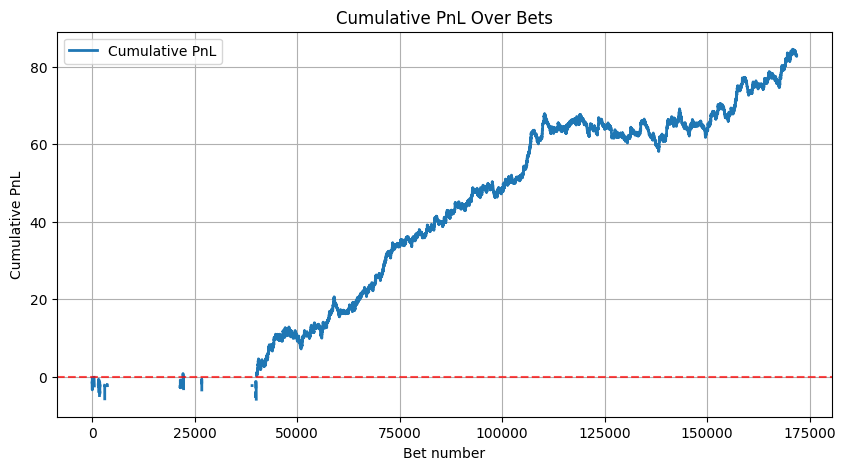

In [55]:
import matplotlib.pyplot as plt

# Assuming you already have df returned from your backtest
# Plot cumulative PnL
plt.figure(figsize=(10, 5))
plt.plot(np.log(df_k["PnL"].cumsum()), label="Cumulative PnL", linewidth=2)
plt.axhline(0, color="red", linestyle="--", alpha=0.7)
plt.title("Cumulative PnL Over Bets")
plt.xlabel("Bet number")
plt.ylabel("Cumulative PnL")
plt.legend()
plt.grid(True)
plt.show()


In [52]:
import numpy as np
import pandas as pd

def backtesting_strategy_fixed(
    pred_probs,          # model probs in [0,1]
    decimal_odds,        # actual decimal odds offered
    results,             # 0/1 outcomes
    stake=1.0,
    min_edge=0.0
):
    pred_probs = np.asarray(pred_probs, dtype=float)
    decimal_odds = np.asarray(decimal_odds, dtype=float)
    results = np.asarray(results, dtype=int)

    # sanity checks
    assert pred_probs.shape == decimal_odds.shape == results.shape
    assert np.all((pred_probs >= 0) & (pred_probs <= 1))

    # raw implied prob from odds (no normalisation!)
    p_mkt = 1.0 / decimal_odds

    # edge = model - market implied prob
    edge = pred_probs - p_mkt

    # bet selection
    mask = edge >= min_edge
    n_bets = int(mask.sum())
    total_staked = n_bets * stake

    # PnL with decimal odds
    win_payout = (decimal_odds - 1.0) * stake
    pnl = np.where(results == 1, win_payout, -stake)
    total_pnl = float(pnl[mask].sum())

    # metrics
    roi_per_bet = (total_pnl / total_staked) if total_staked > 0 else 0.0
    hit_rate = float(results[mask].mean()) if n_bets else 0.0
    avg_edge = float(edge[mask].mean()) if n_bets else 0.0

    summary = {
        "bets": n_bets,
        "total_staked": float(total_staked),
        "total_PnL": total_pnl,
        "ROI_per_bet": roi_per_bet,
        "hit_rate_on_bets": hit_rate,
        "avg_edge_on_bets": avg_edge,
        "total_possible_bets": int(len(pred_probs)),
    }
    bkt_df = pd.DataFrame({
        "pred": pred_probs, "odds": decimal_odds, "p_mkt": p_mkt,
        "edge": edge, "bet": mask.astype(int),
        "result": results, "pnl": pnl
    })
    return bkt_df, summary


In [91]:
bkt_df, summary = backtesting_strategy_fixed(
    pred_probs=bkt_preds,
    decimal_odds=bkt_data_decimal, 
    results=bkt_data_y,
    stake=1.0,
    min_edge=0.1
)
print(summary)

count    171849.000000
mean         22.857245
std          31.782141
min           1.040000
25%           6.100000
50%          12.000000
75%          26.000000
max         566.000000
Name: betting_prob_win, dtype: float64
count    171849.000000
mean          0.120026
std           0.118543
min           0.001767
25%           0.038462
50%           0.083333
75%           0.163934
max           0.961538
Name: betting_prob_win, dtype: float64
{'bets': 12353, 'total_staked': 12353.0, 'total_PnL': 19785.097535242552, 'ROI_per_bet': 1.60164312598094, 'hit_rate_on_bets': 0.3681696753824982, 'avg_edge_on_bets': 0.26666279712968105, 'total_possible_bets': 171849}
